In [ ]:
!pip install ipywidgets 
!jupyter nbextension enable --py widgetsnbextension

In [3]:
import ipywidgets
from ipywidgets import IntProgress

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon 

In [13]:
%matplotlib inline
import autogluon.core as ag
from autogluon.vision import ImageDataset, ImagePredictor
import pandas as pd

In [14]:
dataset = ImageDataset.from_folder('data/validation/')
dataset.head()

,image,label
0,/root/SageMaker-Inventory-monitoring/data/vali...,0
1,/root/SageMaker-Inventory-monitoring/data/vali...,0
2,/root/SageMaker-Inventory-monitoring/data/vali...,0
3,/root/SageMaker-Inventory-monitoring/data/vali...,0
4,/root/SageMaker-Inventory-monitoring/data/vali...,0


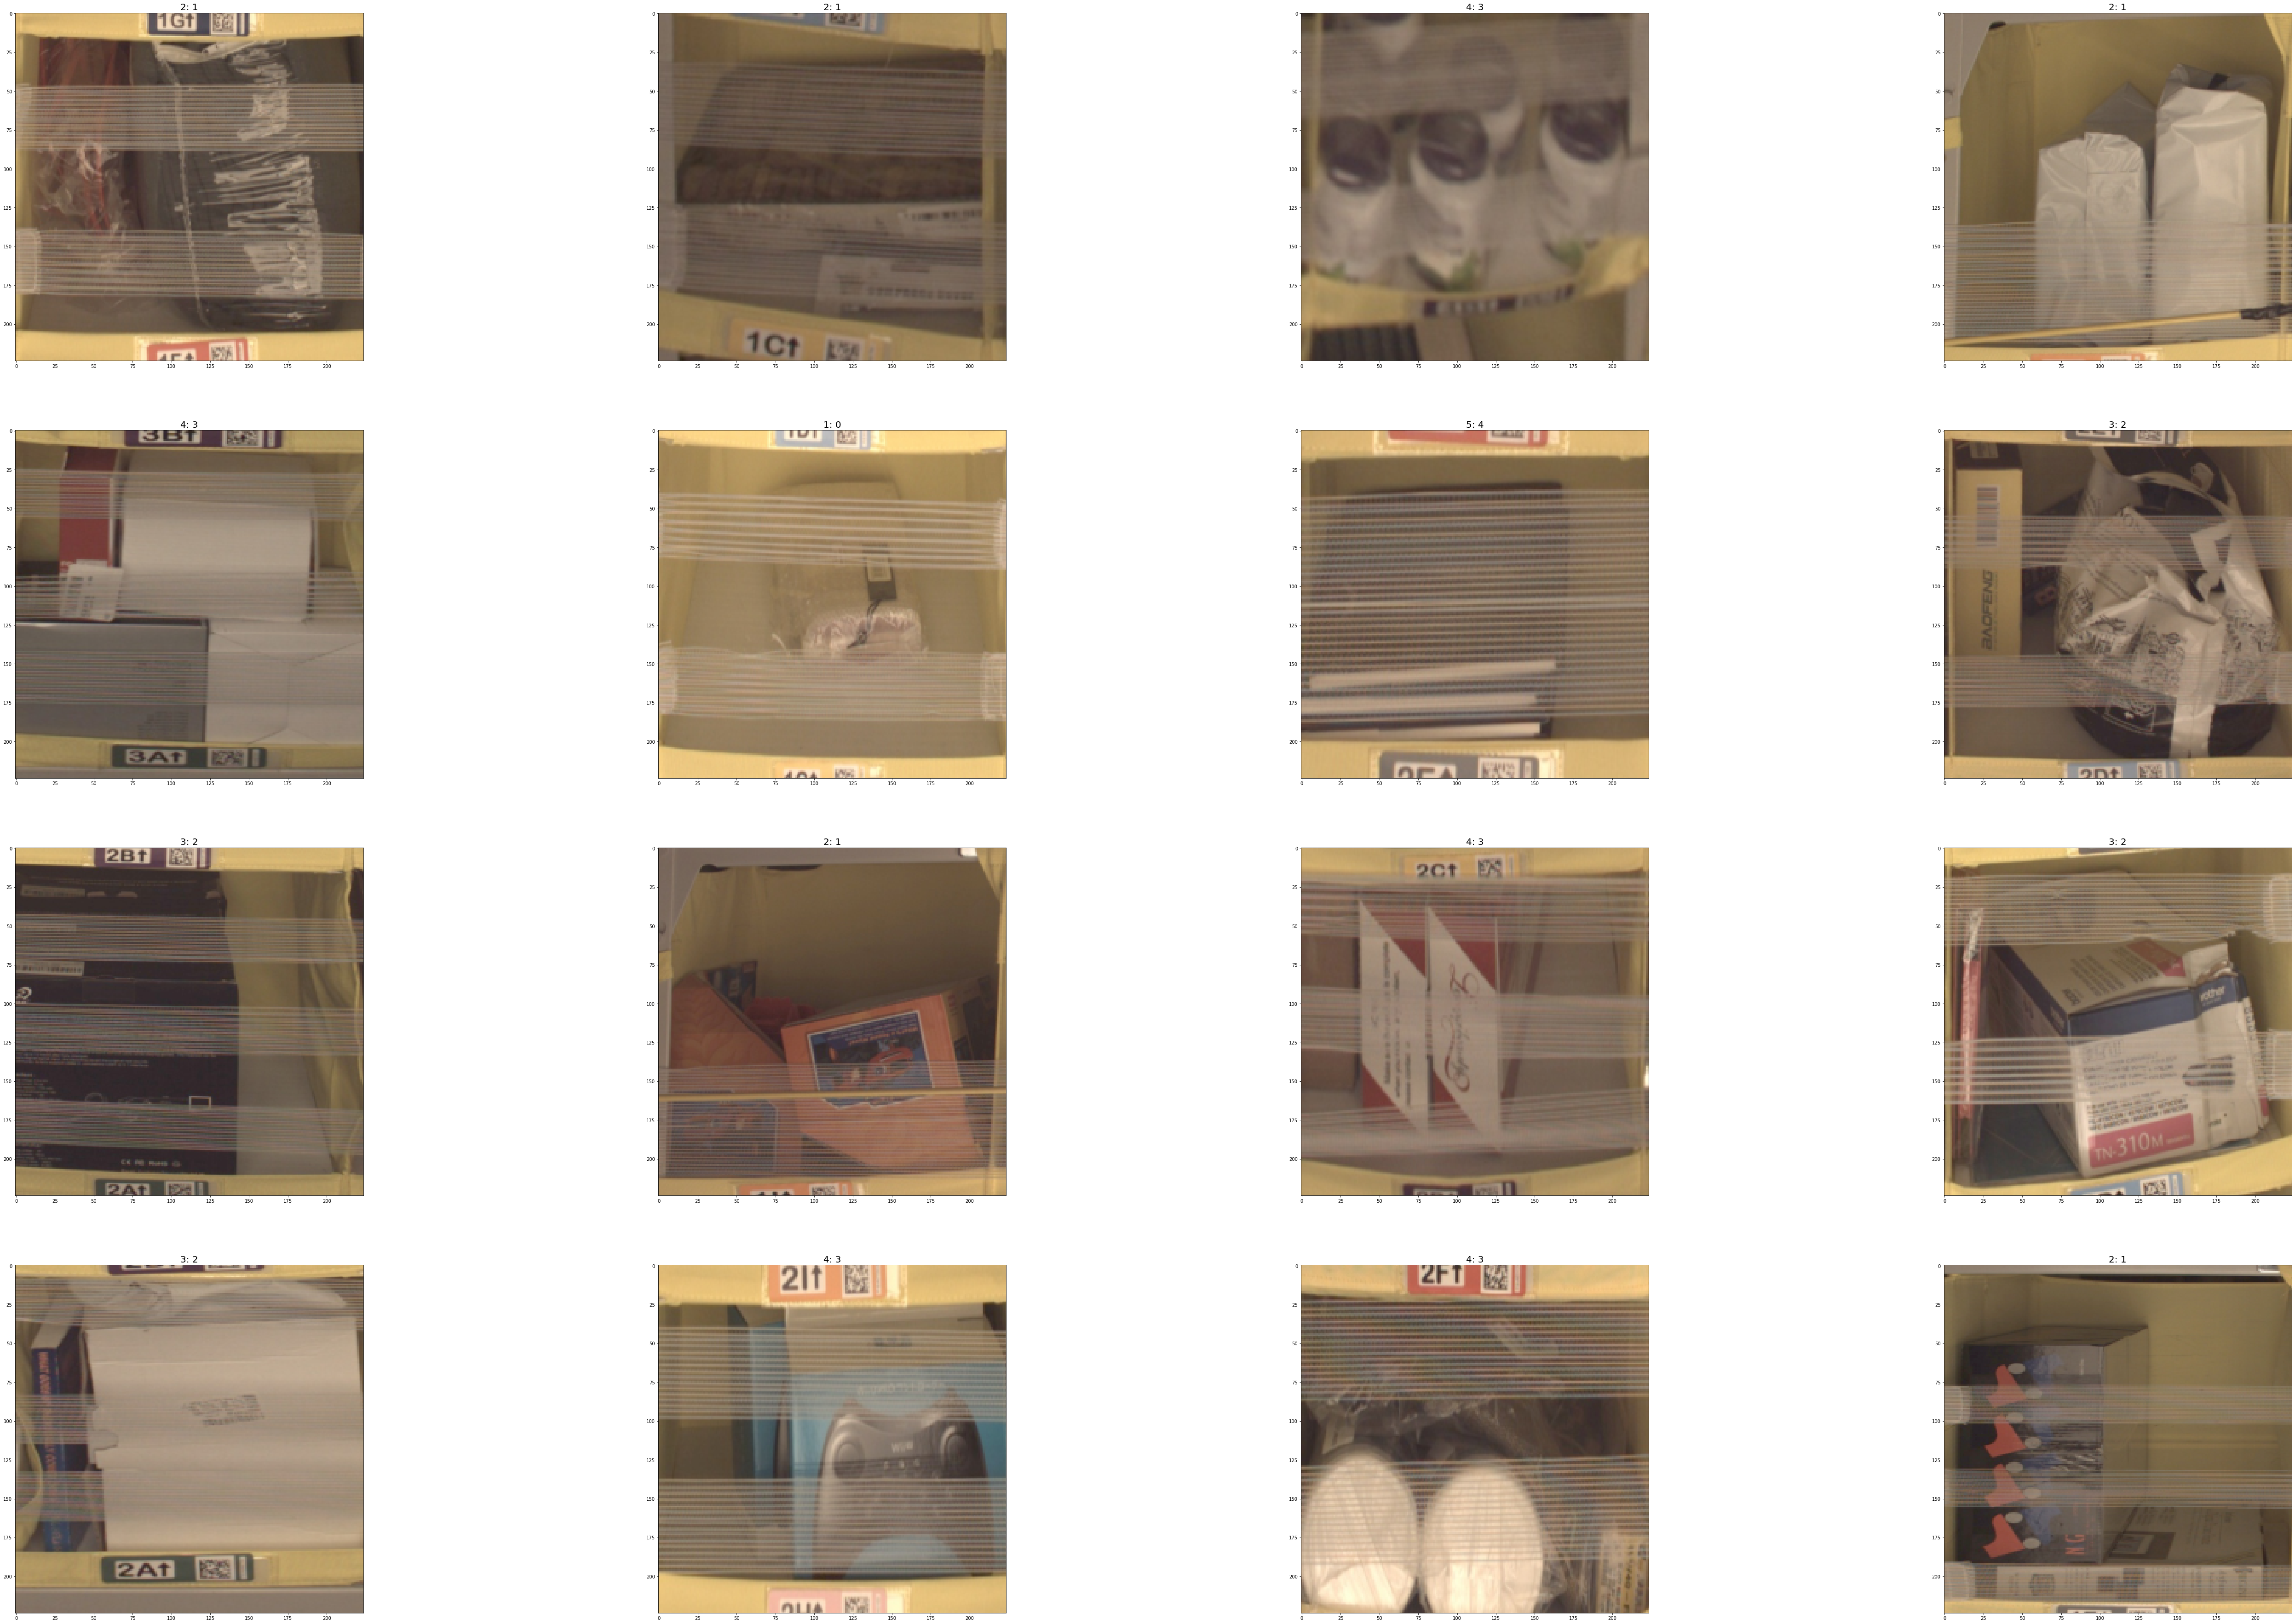

In [15]:
dataset.show_images()

In [16]:
model_list = ImagePredictor.list_models()
#model_list

In [17]:
models = ag.Categorical('coat_tiny', 'inception_v4', 'resnet18', 'resnet26', 'vgg16')

In [18]:
batch_sizes = ag.Categorical(32, 64, 128, 256)
learning_rates = ag.Real(0.001, 0.1, log=True)
hyperparameters={'model': models, 'batch_size': batch_sizes, 'lr': learning_rates, 'epochs': 3}

## First try

In [19]:
predictor = ImagePredictor()
predictor.fit(dataset, 
              time_limit=60*120, 
              hyperparameters=hyperparameters,
              hyperparameter_tune_kwargs={'searcher': 'bayesopt', 'num_trials': 2})

Reset labels to [0, 1, 2, 3, 4]
Randomly split train_data into train[1881]/validation[210] splits.
No GPU detected/allowed, using most conservative search space.
Starting HPO experiments


modified configs(<old> != <new>): {
root.train.early_stop_patience -1 != 10
root.train.epochs    200 != 3
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.gpus            (0,) != ()
root.misc.num_workers 4 != 2
root.misc.seed       42 != 121
root.img_cls.model   resnet101 != coat_tiny
}
Saved config to /root/SageMaker-Inventory-monitoring/de9fee95/.trial_0/config.yaml
Model coat_tiny created, param count:                                         5346305
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
modified configs(<old> != <new>): {
root.train.lr        0.01 != 0.041827321037350665
root.train.early_stop_patience -1 != 10
root.train.epochs    200 != 3
root.train.batch_size 32 != 64
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.gpus            (0,) != ()
root.misc.num_workers 4 != 2
root.misc.seed       42 != 121
root.img_cls.model   res

ValueError: Active hyperparameter 'batch_size▁choice' not specified!

## Second try

ImagePredictor sets accuracy as default eval_metric for classification problems.
Reset labels to [0, 1, 2, 3, 4]
Randomly split train_data into train[1881]/validation[210] splits.
No GPU detected/allowed, using most conservative search space.
Starting HPO experiments


modified configs(<old> != <new>): {
root.train.early_stop_patience -1 != 10
root.train.epochs    200 != 3
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.gpus            (0,) != ()
root.misc.num_workers 4 != 2
root.misc.seed       42 != 296
root.img_cls.model   resnet101 != coat_tiny
}
Saved config to /root/SageMaker-Inventory-monitoring/15f579ff/.trial_0/config.yaml
Model coat_tiny created, param count:                                         5346305
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
modified configs(<old> != <new>): {
root.train.lr        0.01 != 0.018930984005839497
root.train.early_stop_patience -1 != 10
root.train.epochs    200 != 3
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.gpus            (0,) != ()
root.misc.num_workers 4 != 2
root.misc.seed       42 != 296
root.img_cls.model   resnet101 != resnet26
}
Saved conf

Model coat_tiny created, param count:                                         5346305
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Saving Training Curve in /root/SageMaker-Inventory-monitoring/15f579ff/plot_training_curves.png


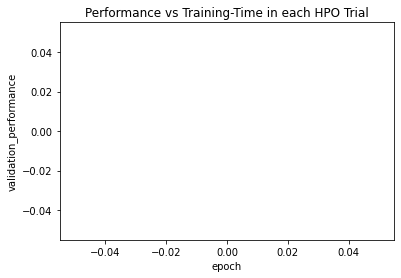

Finished, total runtime is 38.44 s


KeyError: 'estimator'

In [20]:
predictor = ImagePredictor()
predictor.fit(dataset, time_limit=60*120, hyperparameters=hyperparameters,
              hyperparameter_tune_kwargs={#'searcher': 'bayesopt',
                                          'num_trials': 2})